# Create Monthly CESM ice flux files

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import matplotlib

%matplotlib inline

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Stuff that doesn't need to be loaded every time:

In [2]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
tmask = np.array(tmask[0,:,:,:])

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mlons = np.array(mesh.variables['nav_lon'])
mlats = np.array(mesh.variables['nav_lat'])
mlons = np.array(mlons)
mlats = np.array(mlats)

cond = (tmask > 0.1) 
Z_masked = np.ma.masked_where(cond, tmask) 

In [3]:
def save_file(filename, field1, field2, field3):
    ncd = nc.Dataset(filename, 'w', zlib=True)
#     nc_tools.init_dataset_attrs(
#         ncd,
#         title='dust input field',
#         notebook_name='',
#         nc_filepath='./dust_input.nc',
#         comment='NCAR deposition field')

    ncd.createDimension('x',len(mesh.dimensions['x']))
    ncd.createDimension('y',len(mesh.dimensions['y']))
    ncd.createDimension('time_counter',None)
    
    # variables
    dust             = ncd.createVariable('dust', 'float64', ('y','x'))
    dust.units       = 'kg/m2 s'
    dust.long_name   = 'Dust deposition flux'  
    dust.coordinates = 'nav_lon nav_lat'
    dust[:]          = field1[:]
    
    bc_philic             = ncd.createVariable('bc_philic', 'float64', ('y','x'))
    bc_philic.units       = 'kg/m2 s'
    bc_philic.long_name   = 'Hydrophilic black carbon'  
    bc_philic.coordinates = 'nav_lon nav_lat'
    bc_philic[:]          = field2[:]
    
    bc_phobic             = ncd.createVariable('bc_phobic', 'float64', ('y','x'))
    bc_phobic.units       = 'kg/m2 s'
    bc_phobic.long_name   = 'Hydrophobic black carbon'  
    bc_phobic.coordinates = 'nav_lon nav_lat'
    bc_phobic[:]          = field3[:]
    
    print('saved ', filename)

    ncd.close()
    return

In [4]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    LatLonPair = (nav_lon, nav_lat)
    var_out = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='nearest')
    
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

Load data:

In [26]:
folder = '/ocean/brogalla/GEOTRACES/data/NCAR/'
faero_001_nh   = 'merged_faero_ocn001_nh.nc' #hydrophilic black carbon
faero_002_nh   = 'merged_faero_ocn002_nh.nc' #hydrophobic black carbon
faero_003_nh   = 'merged_faero_ocn003_nh.nc' #dust

faero_001_n = nc.Dataset(folder+faero_001_nh)
faero_002_n = nc.Dataset(folder+faero_002_nh)
faero_003_n  = nc.Dataset(folder+faero_003_nh)

In [27]:
ocn001 = faero_001_n.variables['faero_ocn001']
ocn002 = faero_002_n.variables['faero_ocn002']
ocn003 = faero_003_n.variables['faero_ocn003']
ocn001 = np.array(ocn001)
ocn002 = np.array(ocn002)
ocn003 = np.array(ocn003)

In [28]:
print(np.amax(ocn001[:, :,:]), np.amin(ocn001[:, :,:]))

1e+30 0.0


In [7]:
cond = (ocn001 >= 1e30) 
ocn001_masked = np.ma.masked_where(cond, ocn001) 
# np.count_nonzero(ocn001_masked)

In [8]:
cond = (ocn002 >= 1e30) 
ocn002_masked = np.ma.masked_where(cond, ocn002) 
# np.count_nonzero(ocn002_masked)

In [9]:
cond = (ocn003 >= 1e30) 
ocn003_masked = np.ma.masked_where(cond, ocn003) 
# np.count_nonzero(ocn003_masked)

In [10]:
lon  = faero_001_n.variables['TLON']
lat  = faero_001_n.variables['TLAT']
time = faero_001_n.variables['time']

lon = np.array(lon)
for i in range(0,104):
    for j in range(0,320):
        if lon[i,j] >= 180:
            lon[i,j] = -360+lon[i,j]

In [11]:
lons=np.array(lon)
lats=np.array(lat)

Indicate year for which to create files:

In [12]:
file_year = 2002

#### Timing structure:

Time[0] = 192001, time[-1] = 208012

identify array indices corresponding to start and end of file_year:

In [13]:
file_date_start = file_year*365
file_date_end = (file_year+1)*365

In [14]:
start_index = []
end_index = []

for i in range(0,len(time)):
    if time[i] == file_date_start:
        start_index = i
    elif time[i] == file_date_end:
        end_index = i
        
print('start index: ', start_index)
print('end index: ', end_index)

start index:  983
end index:  995


In [25]:
print(np.amax(ocn001_masked[:, :,:]), np.amin(ocn001_masked[:, :,:]))

0.0 0.0


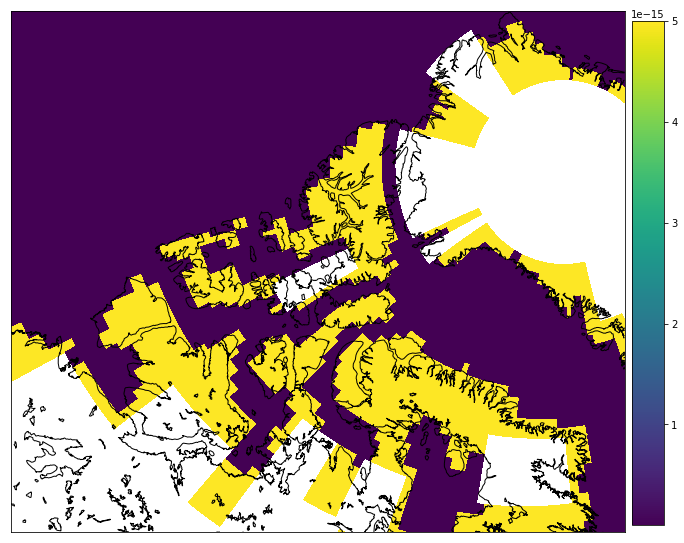

In [22]:
fig, ax1 = plt.subplots(figsize=(11,10))

proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=3.0e6, height=2.55e6, ax=ax1)
proj1.drawcoastlines()

x,y = proj1(np.array(lon), np.array(lat))

cbar=proj1.pcolor(x, y, np.array(ocn001_masked[start_index+3, :, :]), vmin=5e-20, vmax=5e-15)

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
fig.colorbar(cbar, cax=cbar_ax);

Interpolate to ANHA12 grid:

In [ ]:
interp_dst = np.empty((12, 2400, 1632))
interp_bc1  = np.empty((12, 2400, 1632))
interp_bc2  = np.empty((12, 2400, 1632))

# loop over the months:
for i in range(0,12):
    filt_ocn001 = ocn001_masked[start_index+i,:,:][~ocn001_masked[start_index+i,:,:].mask].data
    filt_ocn002 = ocn002_masked[start_index+i,:,:][~ocn002_masked[start_index+i,:,:].mask].data
    filt_ocn003 = ocn003_masked[start_index+i,:,:][~ocn003_masked[start_index+i,:,:].mask].data
    filt_lons1 = lons[~ocn001_masked[start_index+i,:,:].mask].data
    filt_lons2 = lons[~ocn002_masked[start_index+i,:,:].mask].data
    filt_lons3 = lons[~ocn003_masked[start_index+i,:,:].mask].data
    filt_lats1 = lats[~ocn001_masked[start_index+i,:,:].mask].data
    filt_lats2 = lats[~ocn002_masked[start_index+i,:,:].mask].data
    filt_lats3 = lats[~ocn003_masked[start_index+i,:,:].mask].data
    
    interp_dst[i,:,:] = interp_np(filt_lons3, filt_lats3, filt_ocn003, mlons, mlats)
    interp_bc1[i,:,:]  = interp_np(filt_lons1, filt_lats1, filt_ocn001, mlons, mlats)
    interp_bc2[i,:,:]  = interp_np(filt_lons2, filt_lats2, filt_ocn002, mlons, mlats)

In [ ]:
print(np.amax(interp_dst), np.amin(interp_dst))
print(np.amax(interp_bc1), np.amin(interp_bc1))
print(np.amax(interp_bc2), np.amin(interp_bc2))

Write to NetCDF files:

In [ ]:
location='/data/brogalla/atmospheric_forcing/'

In [ ]:
for i in range(1,13):
    if i < 10:
        save_file(location+'ice_flux_y'+str(file_year)+'m0'+str(i)+'.nc',interp_dst[i-1,:,:], \
                 interp_bc1[i-1,:,:], interp_bc2[i-1,:,:])
    else:
        save_file(location+'ice_flux_y'+str(file_year)+'m'+str(i)+'.nc',interp_dst[i-1,:,:], \
                 interp_bc1[i-1,:,:], interp_bc2[i-1,:,:])